# Matrix Factorization 3

사용자의 1 건의 이전 시청 이력에서 여러 건의 시청 이력을 반영하여 보다 정확도를 높혀 봅니다.

이를 위해 필요한 데이터 처리 기법인 데이터 스트리밍 기법과,

Tensorflow Custom 학습 기법을 소개합니다.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

#from tensorboard.plugins import projector

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from IPython.display import clear_output
%load_ext tensorboard

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# MovieLens25M 데이터 준비

In [3]:
import movielens25m

m25m = movielens25m.load_dataset('dataset')
[i for i in m25m.keys()]

['movie_info_kr', 'movie', 'genre', 'series', 'ratings', 'movieinfo']

In [4]:
df_ratings = m25m['ratings']
s_series = m25m['series']
s_genre = m25m['genre']
df_movie = m25m['movie']
df_movieinfo = m25m['movieinfo']

In [5]:
# 사용자의 이전 시점의 평가 이력을 입력 변수로 사용하기 위해
# 시점별로 정렬을 하여, 사용자 별로 시청했던 이력을 시점별로 np.array로 저장합니다.
df_user_hist = df_ratings.sort_values('date').groupby('userId').agg(list).map(lambda x: np.array(x))

In [9]:
df_user_hist.head()

,movieId,rating,date,days
userId,,,,
1,"[5952, 2012, 2011, 1653, 1250, 6539, 6377, 344...","[4.0, 2.5, 2.5, 4.0, 4.0, 3.5, 4.0, 4.0, 4.0, ...","[2006-05-17 12:14:13, 2006-05-17 12:14:28, 200...","[1246.0, 5836.0, 6020.0, 3174.0, 17750.0, 1043..."
2,"[2797, 5952, 1080, 553, 653, 497, 1374, 1653, ...","[1.0, 5.0, 1.0, 2.0, 3.0, 4.0, 4.5, 4.5, 3.0, ...","[2006-03-03 19:51:49, 2006-03-03 19:52:08, 200...","[6482.0, 1171.0, 9695.0, 4451.0, 3563.0, 4683...."
3,"[356, 593, 1270, 1, 480, 2571, 260, 318, 1196,...","[4.0, 4.0, 3.5, 4.0, 2.0, 4.0, 4.0, 4.0, 4.0, ...","[2015-08-13 13:23:19, 2015-08-13 13:23:23, 201...","[7721.0, 8946.0, 10998.0, 7227.0, 8098.0, 5980..."
4,"[97913, 93510, 91630, 93840, 195159, 122914, 1...","[3.5, 4.0, 3.5, 4.5, 5.0, 3.0, 2.0, 3.5, 2.5, ...","[2019-11-16 20:44:51, 2019-11-16 20:44:56, 201...","[2571.0, 2803.0, 2901.0, 2774.0, 345.0, 206.0,..."
5,"[592, 590, 296, 150, 344, 153, 588, 595, 231, ...","[3.0, 3.0, 4.0, 5.0, 4.0, 3.0, 4.0, 3.0, 4.0, ...","[1996-04-29 13:55:55, 1996-04-29 13:55:55, 199...","[2502.0, 2222.0, 597.0, 304.0, 815.0, 318.0, 1..."


In [6]:
df_train = df_ratings.loc[df_ratings['date'] < '2019-01-01'].sample(frac=1)
df_test = df_ratings.loc[df_ratings['date'] >= '2019-01-01']
len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

(0.9519748224956746, 0.048025177504325486)

In [7]:
rating_train_mean = df_train['rating'].astype('float64').mean()
s_userCnt = df_train['userId'].value_counts()
s_movieCnt = df_train['movieId'].value_counts()

In [8]:
import rcmd

**사용자의 평가이력 모델을 업그레이드해봅니다.**

여러개의 이력에서 패턴을 뽑아 사용자 벡터를 만들어 내는 신경망 모델을 만듭니다.

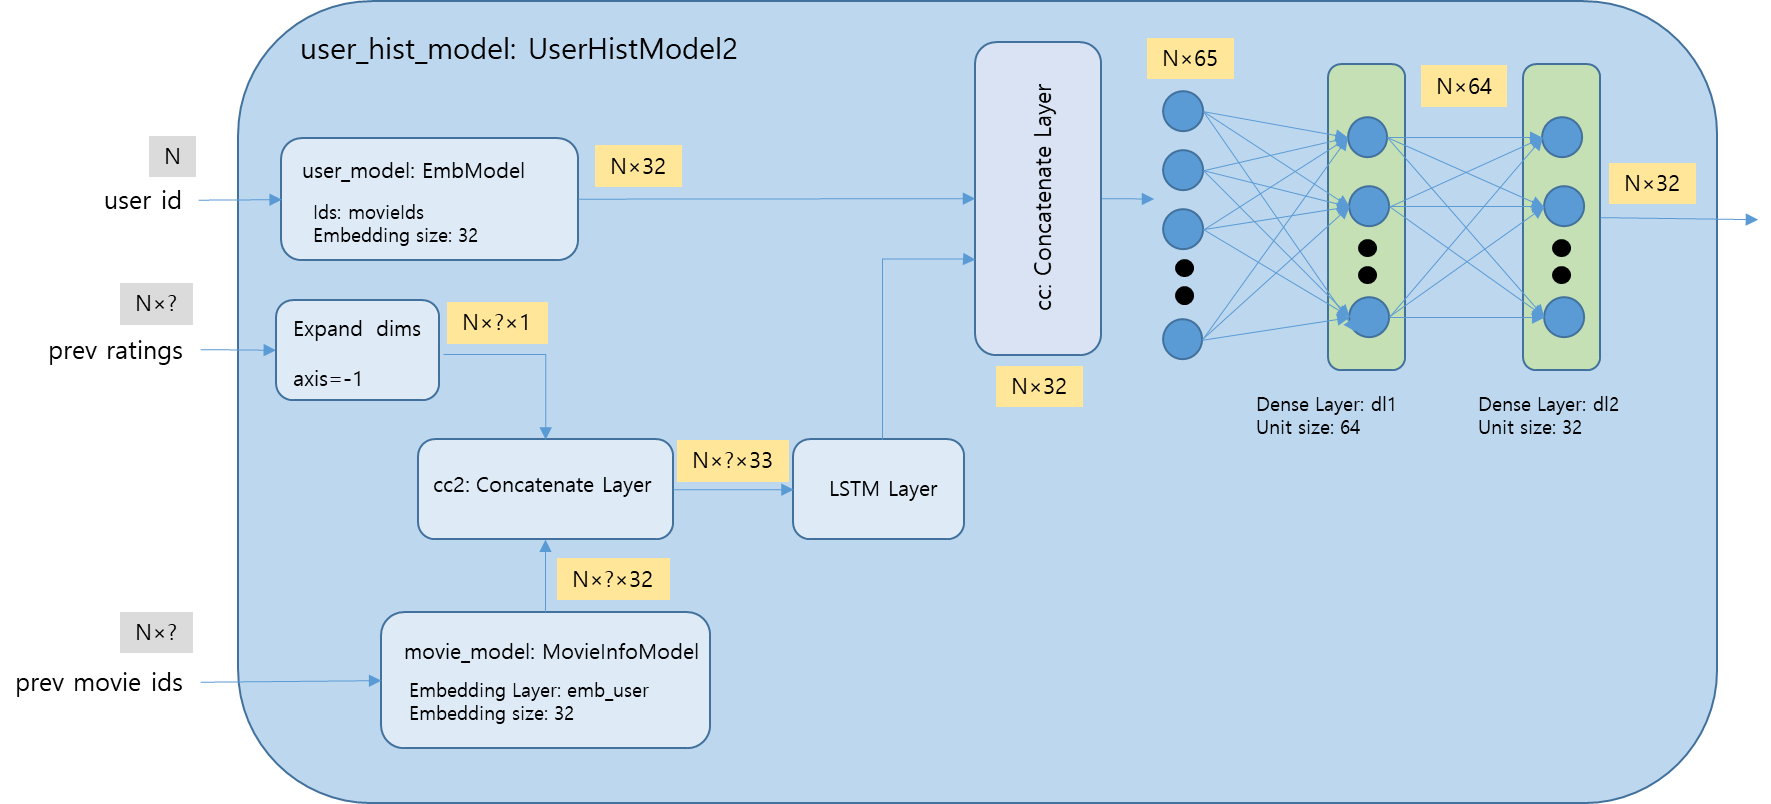

In [10]:
# UserHistModel2에서 평가 순서를 모델링하기 위한 RNN의 기능을 확인해봅니다. 
# 이를 통해 순서를 기반한 패턴을 모델링합니다.
rank = 32
movie_model = rcmd.EmbModel(s_movieCnt.loc[s_movieCnt >= 100].index.values, rank)
movie_info_model = rcmd.MovieInfoModel(df_movieinfo, movie_model, {'genre': 4, 'collection': 8}, rank)

# LSTM이라는 RNN을 사용합니다.
rnn = tf.keras.layers.LSTM(32)

In [11]:
# [1, 2, 3] 영화 평가 순서 Pattern을 뽑고 
# [3, 2] 영화 평가 순서 Pattern을 뽑아
# LSTM 출력 유닛으로 출력을 내어줍니다.
rnn(
    movie_info_model(tf.ragged.constant([[1, 2, 3], [3, 2]]))
)

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[-1.12869162e-02, -1.91228390e-02,  5.66163007e-03,
         6.83766417e-03,  3.89419892e-03, -5.78641077e-04,
         5.67399431e-03, -2.01793551e-03,  1.45989396e-02,
         1.21862171e-02, -6.69348706e-03, -5.88738639e-03,
         5.17159700e-03,  5.44846011e-03,  1.21902013e-02,
        -5.32254810e-03,  3.63484537e-03, -1.04553634e-02,
         7.07097305e-03,  1.21014295e-02, -8.58281087e-03,
        -3.53539293e-03,  3.29275406e-03, -9.01109725e-03,
         1.21783081e-03,  3.60364886e-03,  1.09713832e-02,
         1.65421737e-03,  1.04485499e-02,  3.03652859e-03,
         2.93834065e-03, -8.24722345e-04],
       [-7.92763941e-03, -1.10917315e-02,  3.73017206e-03,
         4.30004625e-03,  1.94928632e-03, -6.64183881e-06,
         4.68519051e-03, -1.64898974e-03,  9.85793769e-03,
         9.36419796e-03, -1.89266098e-03, -6.68297475e-03,
         2.78365542e-03,  4.62410366e-03,  1.02715362e-02,
        -4.20515426e-03

In [12]:
# 순서를 고려하지 않는다면, 평균을 내어 패턴을 뽑는 방법을 쓸 수 있습니다.
tf.reduce_mean(
    movie_info_model(tf.ragged.constant([[1, 2, 3], [3, 2]])),
    axis=-2
)

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[-0.00075529, -0.015187  , -0.02071313,  0.01931651, -0.01423714,
        -0.01274119,  0.0228266 , -0.00542844, -0.0202788 , -0.00533937,
         0.02022846, -0.01058209,  0.01542205,  0.01137811,  0.04585173,
         0.01005351,  0.02698179,  0.01933   , -0.02251164, -0.01251344,
         0.00086709,  0.03476882, -0.02623725, -0.00139036, -0.00199881,
         0.01644393, -0.00206803, -0.03929342, -0.04715078,  0.0061381 ,
         0.00202106,  0.00450155],
       [-0.00049906, -0.005582  , -0.01719061,  0.01569261, -0.01957904,
        -0.00609072,  0.02401893, -0.00813039, -0.01952178, -0.00997056,
         0.02232562, -0.01275676,  0.00326297,  0.01791783,  0.03621761,
         0.01111403,  0.01935076,  0.01861187, -0.02081333, -0.01579045,
         0.0085611 ,  0.02556458, -0.0341126 ,  0.00192915, -0.0058146 ,
         0.02972114, -0.00120183, -0.03804114, -0.04089532,  0.00574531,
         0.00475156,  0.00317891]], dtyp

In [13]:
class UserHistModel2(tf.keras.Model):
    def __init__(self, user_model, movie_model, rank, l2 = 0, rnn = "lstm"):
        """
            user_model: EmbModel
                사용자 임베딩 모델
            movie_model: EmbModel
                영화 임베딩 모델
            rank: int
                출력 벡터의 사이즈
            l2: float
                l2 규제 계수
            rnn: str
                평가 이력 행렬을 통과시킬 RNN 종류: lstm - LSTM, gru - GRU, 그외는 RNN 미사용 평균
        """
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        if rnn == "lstm":
            self.rnn = tf.keras.layers.LSTM(32)
        elif rnn == "gru":
            self.rnn = tf.keras.layers.GRU(32)
        else:
            self.rnn = None
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        # 평가 이력 벡터와 사용자 벡터를 입력으로하는 은닉 밀도층
        # unit size: 64, activator: relu, kernel initializer: HeNormal
        self.dl = tf.keras.layers.Dense(
            64, activation='relu', 
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=reg
        )
        # 출력 밀도레이어
        self.o = tf.keras.layers.Dense(
            rank,
            kernel_regularizer=reg
        )
        # 평가 영화 벡터와 평점을 결합시키기 위한 결합레이어
        self.cc = tf.keras.layers.Concatenate(axis=-1)
        # 평가 이력 벡터와 사용자 벡터를 결합시키기 위한 레이어
        self.cc2 = tf.keras.layers.Concatenate(axis=-1)
        
    def call(self, x, prev_movieIds, prev_ratings, training=False):
        hist_vec = self.cc2([
            self.movie_model(prev_movieIds, training=training), # 사용자 이전 평가 영화 Matrix N×?×rank
            prev_ratings # 사용자 이전 rating Matrix N×?×1
        ]) # N×?×(rank + 1)
        if self.rnn != None:
            hist_vec = self.rnn(hist_vec, training=training) # N×32
        else:
            hist_vec = tf.reduce_mean(hist_vec, axis= -2) # rnn을 사용하지 않는 다면 평균을 사용합니다. N×rank
        vec = self.cc([
            self.user_model(x, training=training), 
            hist_vec
        ]) # N×(32 + rank)
        vec = self.dl(vec) # N×64
        return self.o(vec) # N×rank

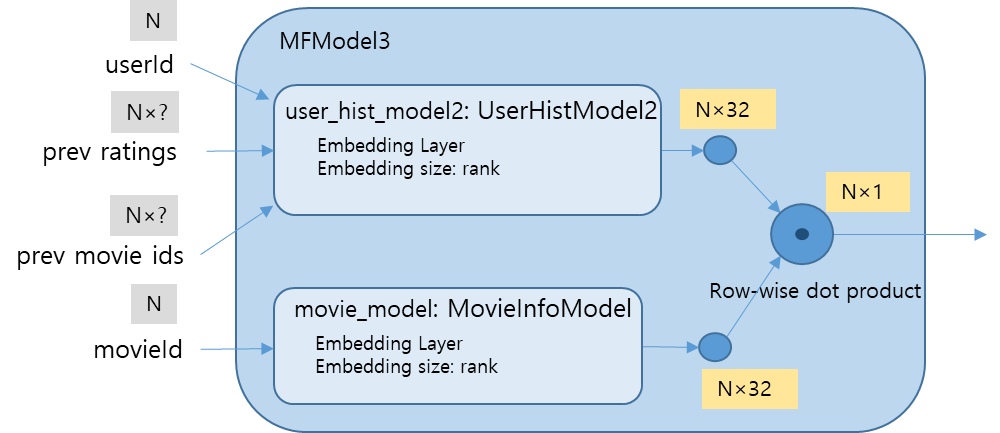

In [14]:
class MFModel3(tf.keras.Model):
    def __init__(self, user_hist_model, movie_model):
        super().__init__()
        self.user_hist_model = user_hist_model
        self.movie_model = movie_model
        self.dot = tf.keras.layers.Dot(axes=-1)
    
    def call(self, x, training=False):
        x_user = self.user_hist_model(
            x['userId'], 
            x['prev_movieIds'], 
            tf.expand_dims(x['prev_ratings'], axis=-1), training=training # N → N×1
        )
        x_movieId = self.movie_model(x['movieId'], training=training)
        return self.dot([x_user, x_movieId])

In [15]:
tf.keras.backend.clear_session()
rank = 32
user_model = rcmd.EmbModel(s_userCnt.loc[s_userCnt >= 150].index.values, rank)
movie_model = rcmd.EmbModel(s_movieCnt.loc[s_movieCnt >= 100].index.values, rank)
movie_info_model = rcmd.MovieInfoModel(df_movieinfo, movie_model, {'genre': 4, 'collection': 8}, rank)
user_hist_model = UserHistModel2(user_model, movie_info_model, rank, rnn='lstm')
mf_model3 = MFModel3(user_hist_model, movie_info_model)
mf_model3({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieIds': tf.ragged.constant([[0, 1], [2]]), 'prev_ratings': tf.ragged.constant([[1.0, 3.5], [2]])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.00597251],
       [-0.01151647]], dtype=float32)>

In [16]:
user_bins = [0, 1, 150, 500, 1000, np.inf]
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
s_user_type.value_counts()

userCnt
[0.0, 1.0)         930474
[150.0, 500.0)      80619
[1000.0, inf)       75826
[1.0, 150.0)        59775
[500.0, 1000.0)     53940
Name: count, dtype: int64

In [17]:
movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).rename('movieCnt')
s_movie_type.value_counts()

movieCnt
[10000.0, inf)       442931
[1000.0, 5000.0)     279785
[5000.0, 10000.0)    190618
[100.0, 1000.0)      152343
[1.0, 100.0)         100575
[0.0, 1.0)            34382
Name: count, dtype: int64

In [18]:
user_mean_model = rcmd.EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1)
movie_mean_model = rcmd.EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1)
mean_model = rcmd.MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
mean_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.4944026],
       [3.5075428]], dtype=float32)>

In [19]:
a_model = rcmd.AdditiveModel([mf_model3, mean_model])
a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieIds': tf.ragged.constant([[0, 1], [2]]), 'prev_ratings': tf.ragged.constant([[1.0, 3.5], [2]])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.48843  ],
       [3.4960263]], dtype=float32)>

**Custom Train Step**

다수의 이전 시청했던 영화 평가 이력을 미리 만들어 놓으면 상당한 메모리가 필요하게 됩니다. 

학습데이터를 전달하기 전에 즉 필요한 양 만큼 이전 평가 이력을 만들어 모델에 전달하려고 합니다. 

이렇게 하려면, compile ~ fit을 사용할 수 없고, 

데이터 처리 루틴에서 처리한 양만큼을 즉 스탭별로 학습시키는 방식으로 바꿔야 합니다. 

이를 위해, Train Step 루틴을 만듭니다.

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
mse = tf.keras.losses.MeanSquaredError()

# Custom Train Step
# @tf.function 
# 피선언된 함수 내부의 Tensor 연산은 Graph 모드로 동작하게 됩니다.
# (Ragged)TensorSpec 는 함수에 입력된 텐서의 Spec을 정의합니다.
@tf.function(
    input_signature = [
        tf.TensorSpec(shape=(None, ), dtype=tf.int64), # userId: N
        tf.TensorSpec(shape=(None, ), dtype=tf.int64), # moveId: N
        tf.RaggedTensorSpec(shape=(None, None), dtype=tf.int64), # prev_movieIds: Nx?
        tf.RaggedTensorSpec(shape=(None, None), dtype=tf.float32), # prev_ratings: Nx?
        tf.TensorSpec(shape=(None,), dtype=tf.float32) # ratings: N
    ]
)
def train_step(userId, movieId, prev_movieIds, prev_ratings, rating):
    # Loss의 경사도를 계산하기 위해, 
    # Loss를 구하기 위한 연산들에서 모델들의 가중치(weight)의 경사도를 기록하게 합니다.
    with tf.GradientTape() as tape:
        prd = a_model({'userId': userId, 'movieId': movieId, 'prev_movieIds': prev_movieIds, 'prev_ratings': prev_ratings}, training=True)
        mse_ = mse(rating, prd)
        regularization_loss = tf.reduce_sum(a_model.losses)
        loss = mse_ + regularization_loss
    metrics = {
        'mse': mse_,
        'loss': loss,
        'regularization_loss': regularization_loss
    }
    variables = a_model.trainable_variables
    # 기록된 모델에 있는 가중치의 경사도를 가져옵니다.
    gradients = tape.gradient(loss, variables)
    # 최적화 모듈에 경사도를 전달하여 모델에 있는 가중치를 업데이트합니다.
    optimizer.apply_gradients(zip(gradients, variables))
    return metrics

In [21]:
from sklearn.metrics import mean_squared_error

def train(hist_cnt = 8, batch_size = 1024):
    # df_train의 위치 인덱스를 batch_size 만큼씩 나눕니다.
    pos = np.hstack([np.arange(0, len(df_train), batch_size), [len(df_train) - batch_size]])
    # 데이터가 특정 범주로 편중이 되면 학습이 잘 되지 않습니다. 
    # 이룰 방지하기 위해 순서를 섞어 줍니다.
    np.random.shuffle(pos)
    pbar = tqdm(pos)
    metric_mse = tf.keras.metrics.Mean()
    metric_loss = tf.keras.metrics.Mean()
    for n, i in enumerate(pbar):
        piece = df_train.iloc[i:i + batch_size]
        # 사용자 이력을 가져 옵니다.
        hist = df_user_hist.loc[piece['userId']]
        tmp = piece['date'].values
        prev_movies = list()
        prev_ratings = list()

        # 해당 시점의 위치 인덱스를 찾고 시점의 hist_cnt만큼의 평가 이력을 가져옵니다.
        for hist_date, hist_movieId, hist_rating, d in zip(hist['date'], hist['movieId'], hist['rating'],piece['date']):
            # 현재 평가시점에 해당하는 위치인덱스를 가져옵니다.
            idx = np.searchsorted(hist_date, d)
            # 가져올 평가 이력의 시작 지점을 계산합니다.
            from_idx  = max(0, idx - hist_cnt)
            # 이전 평가 인덱스를 가져옵니다.
            prev_movies.append(hist_movieId[from_idx:idx] if from_idx < idx else [0])
            # 이전 평가 rating을 가져옵니다.
            prev_ratings.append(hist_rating[from_idx:idx] if from_idx < idx else [0.0])

        # 사용자 / 영화 / 추출한 평가이력 / 점수를 train_step에 전달합니다.
        loss = train_step(
            tf.constant(piece['userId'], dtype=tf.int64),
            tf.constant(piece['movieId'], dtype=tf.int64),
            tf.ragged.constant(prev_movies, dtype=tf.int64),
            tf.ragged.constant(prev_ratings, dtype=tf.float32),
            tf.constant(piece['rating'], dtype=tf.float32)
        )
        metric_mse.update_state(loss['mse'])
        metric_loss.update_state(loss['loss'])
        pbar.set_description("mse {:.3f}, loss {:.3f}".format(metric_mse.result().numpy(), metric_loss.result().numpy()))
        
def predict_test(batch_size):
    pos = np.hstack([np.arange(0, len(df_test),batch_size)])
    prds = []
    pbar = tqdm(pos)
    for n, i in enumerate(pbar):
        piece = df_test.iloc[i:i + batch_size]
        hist = df_user_hist.loc[piece['userId']]
        tmp = piece['date'].values
        prev_movies = list()
        prev_ratings = list()
        for hist_date, hist_movieId, hist_rating, d in zip(hist['date'], hist['movieId'], hist['rating'], piece['date']):
            idx = np.searchsorted(hist_date, d)
            from_idx  = max(0, idx - hist_cnt)
            prev_movies.append(hist_movieId[from_idx:idx] if from_idx < idx else [0])
            prev_ratings.append(hist_rating[from_idx:idx] if from_idx < idx else [0.0])
        prd = a_model({
            'userId': tf.constant(piece['userId']), 
            'movieId': tf.constant(piece['movieId']), 
            'prev_movieIds': tf.ragged.constant(prev_movies), 
            'prev_ratings': tf.ragged.constant(prev_ratings)
        })
        prds.append(prd.numpy())
    return np.squeeze(np.vstack(prds))

In [18]:
verbose = True
epochs = 10
hist_cnt = 8
batch_size = 1024

mse_test, mse_by_userCnt, mse_by_movieCnt = list(), list(), list()
for i in range(epochs):
    train(hist_cnt, batch_size)
    prds = predict_test(batch_size)
    if verbose:
        # 테스트셋의 성능을 구합니다.
        mse_test.append(mean_squared_error(df_test['rating'], prds))
        # 테스트셋 성능을 묶어 데이터프레임을 만듭니다.
        df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
        # 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
        mse_by_userCnt.append(
            df_prd.groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )
        # 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
        mse_by_movieCnt.append(
            df_prd.groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )
        # 종합하여 하나의 데이터프레임으로 만듭니다.
        df_result = pd.concat([
            pd.DataFrame({('', 'test'): mse_test}),
            pd.concat(mse_by_userCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
            ).T,
            pd.concat(mse_by_movieCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
            ).T
        ], axis=1)
        df_result.index = np.arange(1, len(df_result) + 1)
        df_result.name = 'epoch'
        clear_output()
        display(df_result)

userCnt                                              \
        test [0.0, 1.0) [1.0, 150.0) [150.0, 500.0) [500.0, 1000.0)   
1   0.673888   0.680123     0.663623       0.711958        0.618895   
2   0.671287   0.678415     0.662137       0.704994        0.610602   
3   0.666367   0.672814     0.658085       0.700974        0.608862   
4   0.663651   0.669989     0.655113       0.697876        0.608049   
5   0.661597   0.668663     0.652023       0.693962        0.603921   
6   0.663668   0.671958     0.653459       0.692492        0.600539   
7   0.656282   0.664336     0.645502       0.686360        0.593447   
8   0.655181   0.663857     0.644860       0.682624        0.588288   
9   0.650567   0.658759     0.640620       0.679506        0.585006   
10  0.650130   0.658802     0.640346       0.676987        0.582214   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1       0.604111   0.823605     0.724784        0.655986         0.661616   
2       0.598359   0.817579     0.719789        0.648722         0.662488   
3       0.597890   0.817059     0.715323        0.644603         0.658428   
4       0.595770   0.813402     0.706974        0.642210         0.656957   
5       0.589048   0.806788     0.699430        0.639919         0.655666   
6       0.584242   0.802135     0.696947        0.641741         0.658909   
7       0.578679   0.807495     0.690680        0.632921         0.649833   
8       0.575252   0.804637     0.687552        0.632721         0.648521   
9       0.573745   0.809489     0.683120        0.627528         0.643477   
10      0.571186   0.806435     0.679830        0.628501         0.642109   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1           0.663917       0.668909  
2           0.663415       0.665625  
3           0.660081       0.658759  
4           0.659229       0.655694  
5           0.658776       0.654151  
6           0.662898       0.656241  
7           0.655008       0.649391  
8           0.654115       0.648619  
9           0.649208       0.643826  
10          0.647993       0.644679

In [19]:
"""
# 학습 결과를 저장하고자 한다면 주석을 해제하고 실행시키면 됩니다.

with open('mf3.pkl', 'wb') as f:
    pickle.dump({
        'userCnt': s_userCnt,
        'movieCnt': s_movieCnt,
        'movieInfo': df_movieinfo,
        'result': df_result,
        'weights': a_model.get_weights(),
        'rnn': 'lstm'
    }, f)
"""

## 저장된 학습 결과에서 불러와 봅니다.

In [23]:
with open('mf3.pkl', 'rb') as f:
    mf3 = pickle.load(f)
[i for i in mf3.keys()]

['userCnt', 'movieCnt', 'movieInfo', 'result', 'weights', 'rnn']

In [26]:
# 모델을  만듭니다.
tf.keras.backend.clear_session()
rank = 32
user_model = rcmd.EmbModel(mf3['userCnt'].pipe(lambda  x: x.loc[x >= 150].index.values), rank)
movie_model = rcmd.EmbModel(mf3['movieCnt'].pipe(lambda x: x.loc[x >= 100].index.values), rank)
movie_info_model = rcmd.MovieInfoModel(mf3['movieInfo'], movie_model, {'genre': 4, 'collection': 8}, rank)
user_hist_model2 = UserHistModel2(user_model, movie_info_model, rank, rnn="lstm")
mf_model3 = MFModel3(user_hist_model2, movie_info_model)

user_mean_model = rcmd.EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1)
movie_mean_model = rcmd.EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1)
mean_model = rcmd.MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
mean_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

a_model = rcmd.AdditiveModel([mf_model3, mean_model])

# 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieIds': tf.ragged.constant([[0, 1], [2]]), 'prev_ratings': tf.ragged.constant([[1.0, 3.5], [2]])})

# 저장해두었던 가중치를 설정합니다.
a_model.set_weights(mf3['weights'])

In [29]:
hist_cnt = 8
prds = predict_test(1024)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1173/1173 [01:12<00:00, 16.11it/s]


In [30]:
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)

userCnt
[0.0, 1.0)         0.659535
[1.0, 150.0)       0.645509
[150.0, 500.0)     0.680751
[500.0, 1000.0)    0.585476
[1000.0, inf)      0.575169
dtype: float32

movieCnt
[0.0, 1.0)           0.806690
[1.0, 100.0)         0.689855
[100.0, 1000.0)      0.630233
[1000.0, 5000.0)     0.643069
[5000.0, 10000.0)    0.648509
[10000.0, inf)       0.644959
dtype: float32

In [31]:
# 영화 임베딩을 프로젝션해봅니다.

from tensorboard.plugins import projector

# 프로젝션 데이터가 저장될 경로를 만듭니다.
log_dir='logs/m25m_3/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# 메타데이터를 저장합니다.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt > 100].index:
        if i in m25m['movie_info_kr']:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)

# 내용을 저장합니다.
weights =  tf.Variable(movie_info_model(tf.constant(known)))
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [32]:
%tensorboard --logdir logs/m25m_3/ --bind_all